In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

11:42:11 - cmdstanpy - INFO - Chain [1] start processing
11:42:11 - cmdstanpy - INFO - Chain [1] done processing


MAE:  101.61
MAPE: 12.98%


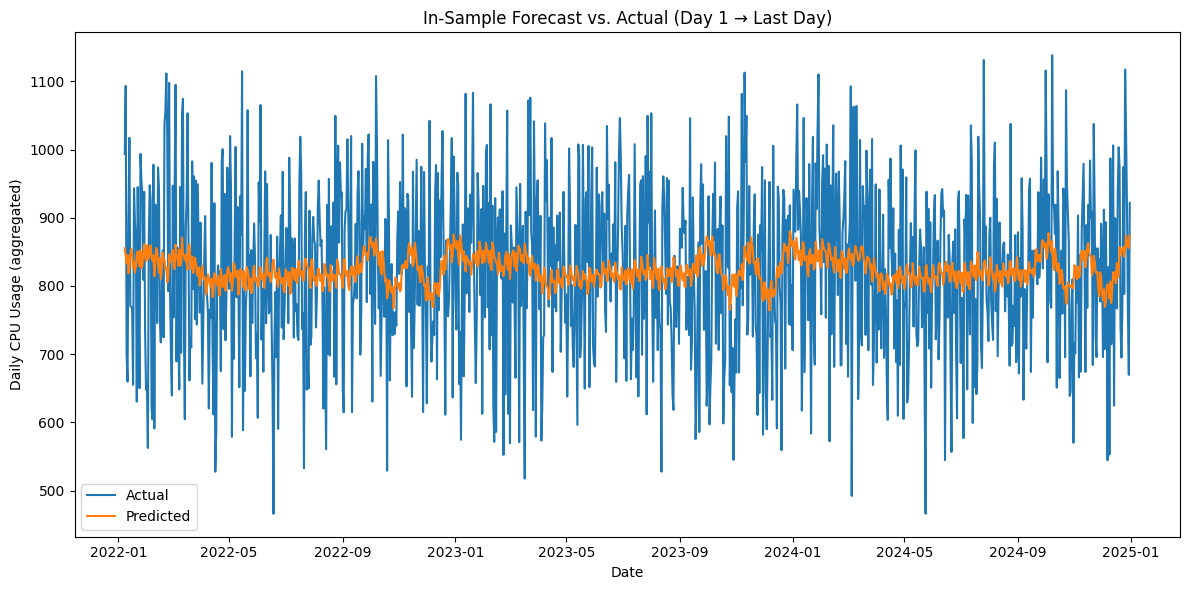

In [4]:
# 1. Load & Aggregate
df = pd.read_csv('../data/cpu_usage_simulated.csv')
df['date'] = pd.to_datetime(df['date'])
df_agg = (df
    .groupby('date', as_index=False)['cpu_used']
    .sum()
    .rename(columns={'date':'ds', 'cpu_used':'y'})
    .sort_values('ds')
    .reset_index(drop=True)
)

# 2. Create lag regressors
df_agg['lag_1'] = df_agg['y'].shift(1)
df_agg['lag_7'] = df_agg['y'].shift(7)
df_model = df_agg.dropna().reset_index(drop=True)

# 3. Configure Prophet with tuned hyper-parameters
m = Prophet(
    seasonality_mode='multiplicative',
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,    # allows moderate flexibility
    seasonality_prior_scale=10.0,   # lets seasonal components adapt
    changepoint_range=0.8           # change-points over first 80% of data
)

# 4. Add regressors to capture non-linearity (spikes)
m.add_regressor('lag_1')
m.add_regressor('lag_7')

# 5. Fit model
m.fit(df_model)

# 6. In-sample forecasting (day 1 → last day)
future = df_model[['ds','lag_1','lag_7']].copy()
forecast = m.predict(future)

# 7. Compute MAE & MAPE
y_true = df_model['y']
y_pred  = forecast['yhat']
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# 1. Select the fields we want
df_output = df_model[['ds', 'y', 'lag_1', 'lag_7']].copy()

# 2. Add Prophet’s predictions and intervals
df_output['yhat']       = forecast['yhat'].values
df_output['yhat_lower'] = forecast['yhat_lower'].values
df_output['yhat_upper'] = forecast['yhat_upper'].values

# 3. (Optional) Reset index or format dates
df_output = df_output.reset_index(drop=True)

# 8. Plot actual vs. predicted
plt.figure(figsize=(12,6))
plt.plot(df_model['ds'], y_true, label='Actual')
plt.plot(df_model['ds'], y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Daily CPU Usage (aggregated)')
plt.title('In-Sample Forecast vs. Actual (Day 1 → Last Day)')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
df_output.head()

,ds,y,lag_1,lag_7,yhat,yhat_lower,yhat_upper
0,2022-01-08,993.582244,822.129429,766.439660,855.428298,702.513915,1023.692888
1,2022-01-09,1093.205791,993.582244,874.398300,843.822557,693.874774,999.293622
2,2022-01-10,698.172105,1093.205791,855.641971,832.913416,670.999938,991.856345
3,2022-01-11,659.843735,698.172105,798.959822,845.149138,684.892121,1000.343383
4,2022-01-12,892.543251,659.843735,618.554897,818.465916,664.802739,972.287019


In [8]:
mae  = mean_absolute_error(df_output['y'], df_output['yhat'])
mape = mean_absolute_percentage_error(df_output['y'], df_output['yhat']) * 100
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  101.61
MAPE: 12.98%


In [14]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from itertools import product

# 1. Load & aggregate
df = pd.read_csv('../data/cpu_usage_simulated.csv', parse_dates=['date'])
df = (df
      .groupby('date', as_index=False)['cpu_used']
      .sum()
      .rename(columns={'date':'ds','cpu_used':'y'})
      .sort_values('ds')
      .reset_index(drop=True)
)

# 2. Feature engineering: lags, rolling stats, calendar dummies
for lag in [1,2,3,7]:
    df[f'lag_{lag}'] = df['y'].shift(lag)
df['rolling_mean_7'] = df['y'].rolling(7).mean()
df['rolling_std_7']  = df['y'].rolling(7).std()

# Day-of-week dummies
dow = pd.get_dummies(df['ds'].dt.weekday, prefix='dow')
df = pd.concat([df, dow], axis=1)

# Drop initial NaNs
df_model = df.dropna().reset_index(drop=True)

# 3. Define hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.2],
    'seasonality_prior_scale': [5.0, 10.0, 20.0],
    'seasonality_mode': ['additive','multiplicative']
}

# 4. Grid search
results = []
for cps, sps, mode in product(param_grid['changepoint_prior_scale'],
                              param_grid['seasonality_prior_scale'],
                              param_grid['seasonality_mode']):
    m = Prophet(
        seasonality_mode=mode,
        weekly_seasonality=False,
        yearly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps,
        changepoint_range=0.8
    )
    # add regressors
    for col in ['lag_1','lag_2','lag_3','lag_7','rolling_mean_7','rolling_std_7'] + list(dow.columns):
        m.add_regressor(col)
    # optional: add monthly seasonality
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    m.fit(df_model)
    # in-sample predict
    future = df_model.drop(columns=['y','ds'])
    future['ds'] = df_model['ds']
    fc = m.predict(future)
    y_true = df_model['y']
    y_pred = fc['yhat']
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    results.append({
        'cps': cps, 'sps': sps, 'mode': mode,
        'MAE': mae, 'MAPE': mape
    })

# 5. Pick best
df_res = pd.DataFrame(results)
best = df_res.sort_values(['MAPE','MAE']).iloc[0]
print("Best params:", best.to_dict())

# 6. Retrain final model with best params
m_final = Prophet(
    seasonality_mode=best['mode'],
    weekly_seasonality=False,
    yearly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best['cps'],
    seasonality_prior_scale=best['sps'],
    changepoint_range=0.8
)
for col in ['lag_1','lag_2','lag_3','lag_7','rolling_mean_7','rolling_std_7'] + list(dow.columns):
    m_final.add_regressor(col)
m_final.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m_final.fit(df_model)

# 7. Make in-sample predictions & combine
future = df_model.drop(columns=['y','ds'])
future['ds'] = df_model['ds']
fc_final = m_final.predict(future)

df_output = df_model[['ds','y'] + ['lag_1','lag_2','lag_3','lag_7','rolling_mean_7','rolling_std_7'] + list(dow.columns)].copy()
df_output['yhat']        = fc_final['yhat'].values
df_output['yhat_lower']  = fc_final['yhat_lower'].values
df_output['yhat_upper']  = fc_final['yhat_upper'].values

# 8. Inspect
# print(df_output.head(15))
# Optionally save:
# df_output.to_csv('cpu_prophet_enhanced.csv', index=False)



11:54:00 - cmdstanpy - INFO - Chain [1] start processing
11:54:01 - cmdstanpy - INFO - Chain [1] done processing
11:54:01 - cmdstanpy - INFO - Chain [1] start processing
11:54:01 - cmdstanpy - INFO - Chain [1] done processing
11:54:01 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:03 - cmdstanpy - INFO - Chain [1] start processing
11:54:03 - cmdstanpy - INFO - Chain [1] done processing
11:54:04 - cmdstanpy - INFO - Chain [1] start processing
11:54:04 - cmdstanpy - INFO - Chain [1]

Best params: {'cps': 0.2, 'sps': 10.0, 'mode': 'multiplicative', 'MAE': 86.28663832977043, 'MAPE': 10.945356159712327}


11:54:07 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
df_output.head()

,ds,y,lag_1,lag_2,lag_3,lag_7,rolling_mean_7,rolling_std_7,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,yhat,yhat_lower,yhat_upper
0,2022-01-08,993.582244,822.129429,947.415190,618.554897,766.439660,844.383122,120.734245,False,False,False,False,False,True,False,879.239895,753.954443,1018.992785
1,2022-01-09,1093.205791,993.582244,822.129429,947.415190,874.398300,875.641335,153.640721,False,False,False,False,False,False,True,835.692553,704.083245,971.916646
2,2022-01-10,698.172105,1093.205791,993.582244,822.129429,855.641971,853.145640,167.921502,True,False,False,False,False,False,False,750.736829,631.039881,886.161543
3,2022-01-11,659.843735,698.172105,1093.205791,993.582244,798.959822,833.271913,182.961997,False,True,False,False,False,False,False,747.899941,603.353635,892.619289
4,2022-01-12,892.543251,659.843735,698.172105,1093.205791,618.554897,872.413107,156.809873,False,False,True,False,False,False,False,874.904500,735.928869,1004.630389


In [19]:
mae  = mean_absolute_error(df_output['y'], df_output['yhat'])
mape = mean_absolute_percentage_error(df_output['y'], df_output['yhat']) * 100
smape = smape(df_output['y'], df_output['yhat'])
print(f"SMAPE: {smape:.2f}%")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

SMAPE: 10.65%
MAE:  86.29
MAPE: 10.95%


In [ ]:

def smape_fn(y_true, y_pred):
    """
    Compute Symmetric Mean Absolute Percentage Error.
    """
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# 1. Load & aggregate
df = pd.read_csv('../data/cpu_usage_simulated.csv', parse_dates=['date'])
df = (df
      .groupby('date', as_index=False)['cpu_used']
      .sum()
      .rename(columns={'date':'ds','cpu_used':'y'})
      .sort_values('ds')
      .reset_index(drop=True)
)

# 2. Feature engineering
for lag in [1,2,3,7]:
    df[f'lag_{lag}'] = df['y'].shift(lag)
df['rolling_mean_7'] = df['y'].rolling(7).mean()
df['rolling_std_7']  = df['y'].rolling(7).std()
dow = pd.get_dummies(df['ds'].dt.weekday, prefix='dow')
df = pd.concat([df, dow], axis=1)
df_model = df.dropna().reset_index(drop=True)

# 3. Hyper‐parameter grid
param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.2],
    'seasonality_prior_scale': [5.0, 10.0, 20.0],
    'seasonality_mode': ['additive','multiplicative']
}

# 4. Grid search with SMAPE
results = []
regressors = ['lag_1','lag_2','lag_3','lag_7','rolling_mean_7','rolling_std_7'] + list(dow.columns)

for cps, sps, mode in product(param_grid['changepoint_prior_scale'],
                              param_grid['seasonality_prior_scale'],
                              param_grid['seasonality_mode']):

    m = Prophet(
        seasonality_mode=mode,
        weekly_seasonality=False,
        yearly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps,
        changepoint_range=0.8
    )
    for col in regressors:
        m.add_regressor(col)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    m.fit(df_model)
    
    # in-sample predict
    future = df_model[['ds'] + regressors].copy()
    fc = m.predict(future)
    y_true = df_model['y'].values
    y_pred = fc['yhat'].values
    
    mae_val  = mean_absolute_error(y_true, y_pred)
    mape_val = mean_absolute_percentage_error(y_true, y_pred) * 100
    smape_val= smape_fn(y_true, y_pred)
    
    results.append({
        'cps': cps,
        'sps': sps,
        'mode': mode,
        'MAE': mae_val,
        'MAPE': mape_val,
        'SMAPE': smape_val
    })

# 5. Select best by SMAPE, then MAPE
df_res = pd.DataFrame(results)
best = df_res.sort_values(['SMAPE','MAPE','MAE']).iloc[0]
print("Best hyper-parameters:")
print(best)

# 6. Retrain final model
m_final = Prophet(
    seasonality_mode=best['mode'],
    weekly_seasonality=False,
    yearly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best['cps'],
    seasonality_prior_scale=best['sps'],
    changepoint_range=0.8
)
for col in regressors:
    m_final.add_regressor(col)
m_final.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m_final.fit(df_model)

# 7. In-sample forecast & combine
future = df_model[['ds'] + regressors].copy()
fc_final = m_final.predict(future)

df_output = df_model[['ds','y'] + regressors].copy()
df_output['yhat']       = fc_final['yhat'].values
df_output['yhat_lower'] = fc_final['yhat_lower'].values
df_output['yhat_upper'] = fc_final['yhat_upper'].values

# 8. Compute final metrics
mae_final   = mean_absolute_error(df_output['y'], df_output['yhat'])
mape_final  = mean_absolute_percentage_error(df_output['y'], df_output['yhat'])*100
smape_final = smape_fn(df_output['y'].values, df_output['yhat'].values)
print(f"\nFinal In-Sample Metrics:\n MAE: {mae_final:.2f}\n MAPE: {mape_final:.2f}%\n SMAPE: {smape_final:.2f}%\n")


12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:15 - cmdstanpy - INFO - Chain [1] start processing
12:07:15 - cmdstanpy - INFO - Chain [1] done processing
12:07:15 - cmdstanpy - INFO - Chain [1] start processing
12:07:15 - cmdstanpy - INFO - Chain [1] done processing
12:07:15 - cmdstanpy - INFO - Chain [1] start processing
12:07:15 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:16 - cmdstanpy - INFO - Chain [1] start processing
12:07:16 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1] done processing
12:07:17 - cmdstanpy - INFO - Chain [1] start processing
12:07:17 - cmdstanpy - INFO - Chain [1]

Best hyper-parameters:
cps                 0.2
sps                10.0
mode     multiplicative
MAE           86.286638
MAPE          10.945356
SMAPE          10.64906
Name: 15, dtype: object


12:07:21 - cmdstanpy - INFO - Chain [1] done processing



Final In-Sample Metrics:
 MAE: 86.29
 MAPE: 10.95%
 SMAPE: 10.65%

          ds            y        lag_1        lag_2        lag_3        lag_7  \
0 2022-01-08   993.582244   822.129429   947.415190   618.554897   766.439660   
1 2022-01-09  1093.205791   993.582244   822.129429   947.415190   874.398300   
2 2022-01-10   698.172105  1093.205791   993.582244   822.129429   855.641971   
3 2022-01-11   659.843735   698.172105  1093.205791   993.582244   798.959822   
4 2022-01-12   892.543251   659.843735   698.172105  1093.205791   618.554897   
5 2022-01-13  1017.091845   892.543251   659.843735   698.172105   947.415190   
6 2022-01-14   771.077892  1017.091845   892.543251   659.843735   822.129429   
7 2022-01-15   769.423855   771.077892  1017.091845   892.543251   993.582244   
8 2022-01-16   766.546690   769.423855   771.077892  1017.091845  1093.205791   
9 2022-01-17   655.069522   766.546690   769.423855   771.077892   698.172105   

   rolling_mean_7  rolling_std_7  dow_0 

In [23]:
df_output.head()

,ds,y,lag_1,lag_2,lag_3,lag_7,rolling_mean_7,rolling_std_7,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,yhat,yhat_lower,yhat_upper
0,2022-01-08,993.582244,822.129429,947.415190,618.554897,766.439660,844.383122,120.734245,False,False,False,False,False,True,False,879.239895,736.165420,1013.110253
1,2022-01-09,1093.205791,993.582244,822.129429,947.415190,874.398300,875.641335,153.640721,False,False,False,False,False,False,True,835.692553,703.959835,971.979619
2,2022-01-10,698.172105,1093.205791,993.582244,822.129429,855.641971,853.145640,167.921502,True,False,False,False,False,False,False,750.736829,620.488018,889.117377
3,2022-01-11,659.843735,698.172105,1093.205791,993.582244,798.959822,833.271913,182.961997,False,True,False,False,False,False,False,747.899941,614.222084,881.583075
4,2022-01-12,892.543251,659.843735,698.172105,1093.205791,618.554897,872.413107,156.809873,False,False,True,False,False,False,False,874.904500,744.920870,1019.497694


In [25]:
import pandas as pd
import numpy as np
from scipy.stats  import boxcox
from scipy.special import inv_boxcox
from prophet import Prophet
# Attempt to import Prophet from either package

from sklearn.metrics  import mean_absolute_error, mean_absolute_percentage_error
from itertools  import product

def smape_fn(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error."""
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# 1. Load & aggregate daily CPU usage
df = pd.read_csv('../data/cpu_usage_simulated.csv', parse_dates=['date'])
df = (df
      .groupby('date', as_index=False)['cpu_used']
      .sum()
      .rename(columns={'date':'ds','cpu_used':'y'})
      .sort_values('ds')
      .reset_index(drop=True)
)

# 2. Box–Cox transform to stabilize variance
df['y_box'], λ = boxcox(df['y'] + 1)

# 3. Feature engineering: lags, rolling stats, weekday dummies
lags = [1,2,3,7,14,30]
for lag in lags:
    df[f'lag_{lag}'] = df['y_box'].shift(lag)

df['roll_mean_7'] = df['y_box'].rolling(7).mean()
df['roll_std_7']  = df['y_box'].rolling(7).std()

dow = pd.get_dummies(df['ds'].dt.weekday, prefix='dow')
df = pd.concat([df, dow], axis=1)

df_model = df.dropna().reset_index(drop=True)

# 4. Hyperparameter grid for Prophet
param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.2],
    'seasonality_prior_scale': [5.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}
regressors = [f'lag_{lag}' for lag in lags] + ['roll_mean_7', 'roll_std_7'] + list(dow.columns)

# 5. Grid search minimizing SMAPE
results = []
cols = ['ds', 'y_box'] + regressors
for cps, sps, mode in product(param_grid['changepoint_prior_scale'],
                              param_grid['seasonality_prior_scale'],
                              param_grid['seasonality_mode']):
    m = Prophet(
        seasonality_mode=mode,
        weekly_seasonality=False,
        yearly_seasonality=True,
        daily_seasonality=False,
        changepoint_prior_scale=cps,
        seasonality_prior_scale=sps,
        changepoint_range=0.8
    )
    for col in regressors:
        m.add_regressor(col)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    df_train = df_model[cols].rename(columns={'y_box':'y'})
    m.fit(df_train)
    # m.fit(df_model.rename(columns={'y_box':'y'}))

    future = df_model[['ds'] + regressors].copy()
    fc     = m.predict(future)
    y_pred = inv_boxcox(fc['yhat'], λ) - 1
    y_true = df_model['y'].values

    results.append({
        'cps':   cps,
        'sps':   sps,
        'mode':  mode,
        'MAE':   mean_absolute_error(y_true, y_pred),
        'MAPE':  mean_absolute_percentage_error(y_true, y_pred)*100,
        'SMAPE': smape_fn(y_true, y_pred)
    })

df_res = pd.DataFrame(results)
best   = df_res.sort_values(['SMAPE','MAPE','MAE']).iloc[0]
print("Best hyper‐parameters:", best.to_dict())

# 6. Retrain final model
m_final = Prophet(
    seasonality_mode=best['mode'],
    weekly_seasonality=False,
    yearly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best['cps'],
    seasonality_prior_scale=best['sps'],
    changepoint_range=0.8
)
for col in regressors:
    m_final.add_regressor(col)
m_final.add_seasonality(name='monthly', period=30.5, fourier_order=5)
df_train = df_model[cols].rename(columns={'y_box':'y'})
m_final.fit(df_train)
# m_final.fit(df_model.rename(columns={'y_box':'y'}))

# 7. Forecast & invert
future = df_model[['ds'] + regressors].copy()
fc     = m_final.predict(future)
df_model['yhat']       = inv_boxcox(fc['yhat'], λ) - 1
df_model['yhat_lower'] = inv_boxcox(fc['yhat_lower'], λ) - 1
df_model['yhat_upper'] = inv_boxcox(fc['yhat_upper'], λ) - 1

# 8. Combine actual & predicted
df_output = df_model[['ds','y','yhat','yhat_lower','yhat_upper'] + regressors].copy()

# 9. Final metrics
mae_final   = mean_absolute_error(df_output['y'], df_output['yhat'])
mape_final  = mean_absolute_percentage_error(df_output['y'], df_output['yhat'])*100
smape_final = smape_fn(df_output['y'], df_output['yhat'])
print(f"\nFinal Metrics:\n MAE: {mae_final:.2f}\n MAPE: {mape_final:.2f}%\n SMAPE: {smape_final:.2f}%\n")

# 10. Inspect first rows
# print(df_output.head(15))

# (Optional) save to CSV:
# df_output.to_csv('cpu_prophet_enhanced_output.csv', index=False)


12:44:06 - cmdstanpy - INFO - Chain [1] start processing
12:44:07 - cmdstanpy - INFO - Chain [1] done processing
12:44:07 - cmdstanpy - INFO - Chain [1] start processing
12:44:07 - cmdstanpy - INFO - Chain [1] done processing
12:44:07 - cmdstanpy - INFO - Chain [1] start processing
12:44:07 - cmdstanpy - INFO - Chain [1] done processing
12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1] done processing
12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1] done processing
12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1] done processing
12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing
12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing
12:44:10 - cmdstanpy - INFO - Chain [1] start processing
12:44:10 - cmdstanpy - INFO - Chain [1]

Best hyper‐parameters: {'cps': 0.05, 'sps': 10.0, 'mode': 'multiplicative', 'MAE': 86.23124748317572, 'MAPE': 10.967739779074178, 'SMAPE': 10.649894087594296}


12:44:11 - cmdstanpy - INFO - Chain [1] done processing



Final Metrics:
 MAE: 86.23
 MAPE: 10.97%
 SMAPE: 10.65%



In [27]:
df_output.head()

,ds,y,yhat,yhat_lower,yhat_upper,lag_1,lag_2,lag_3,lag_7,lag_14,lag_30,roll_mean_7,roll_std_7,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,2022-01-31,647.766521,863.138648,723.324671,1000.037832,1885.422090,2506.425900,2110.261046,1635.694810,1650.099434,1981.263650,2266.673070,396.708797,True,False,False,False,False,False,False
1,2022-02-01,655.217791,838.865834,695.553638,978.748641,1628.692048,1885.422090,2506.425900,2680.760632,2522.904491,2310.022755,2119.497904,408.411920,False,True,False,False,False,False,False
2,2022-02-02,562.536037,803.060977,663.373415,937.052715,1650.534468,1628.692048,1885.422090,2561.787150,2372.664467,2252.396414,1950.944579,437.862354,False,False,True,False,False,False,False
3,2022-02-03,869.351822,835.281007,695.620912,956.177057,1381.913872,1650.534468,1628.692048,2493.362628,2293.586736,2079.534399,1922.535315,401.767450,False,False,False,True,False,False,False
4,2022-02-04,947.579352,848.328151,714.995143,980.984083,2294.497780,1381.913872,1650.534468,2110.261046,1577.761587,1543.466979,1983.468321,462.706372,False,False,False,False,True,False,False
